In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import scipy
%reload_ext autoreload
from Schroedinger1D import Schroedinger1D
%autoreload 2


# Non-linear Bayesian inference- Schrödinger model
Consider the Schrödinger equation defined on $\mathcal{X}=[0,1]$ with boundary values $u(0)=u(1)=1$: <br>
$$\begin{cases}
\mathcal{L}_{f}u=\frac{\Delta u(x)}{2}-fu(x)=\frac{1}{2}\frac{\partial^2 u(x)}{\partial x^2}-fu(x)=0 &\text{ on } \mathcal{X} \\
u(x)=1 &\text{ on } \partial\mathcal{X} 
\end{cases},$$
that in the  one dimensional case becomes a second order ODE. <br>
The aim is that of deriving through the pCN algorithm (MCMC) a Bayesian estimate of the parameter $f:\mathcal{X}\to\mathbb{R}$. The parameter is defined such that $f(x)=f(\theta(x))=e^{\theta(x)}$, where the function $\theta$ is then the actual parameter. We assume on it a GP prior with Matern covariance kernel and the observations of the solution $u$, generated by perturbing a reference solution, are assumed $i.i.d$. <br>
The reference solution, considering a discretization of $[0,1]$ of $N=100$ points, is obtained by solving the ODE using the finite difference method by which: $u^{''}(t_i)=\frac{u(t_{i+1})-2u(t_i)+u(t_{i-1})}{\Delta t^2} \ i\in\{1,\dots, N\}$. <br>
The same discretization scheme ($N=100$) is used to discretize the Gaussian Process prior. 



In the experiments below different assumptions on the smoothness of $f_{\theta_0}$ will be considered, thus different values for the parameter $\nu$ of the Matern covariance kernel. The considered values are: 2.5,3.5. Finally, the case $\nu\to\infty$, is considered as well. 

pCN implementation:

In [2]:
def perform_pCN(model: Schroedinger1D, T: int, beta=0.5):
    """The function performs the preconditioned Crank-Nicolson algorithm  with beta=0.5 as default value and T iterations.
    The parameter beta is tuned online in a way  that the avg acceptance probability is around 30%."""
    acceptance_probs=[]
    samples=np.zeros((model.N, T))
    samples[:,0]=np.random.normal(0,1,model.N) 
    verbose=T/10
    t_up = 100  #update beta every 100 iterations.
    for t in range(1,T):
        if(t%verbose==0):
            print("Iteration: ", t)
        if (t%t_up == 0) and (t>0) :
            #tune beta--> if avg acceptance prob is too small, reduce it (too large step size leads to many rejection). If avg acceptance prob is too high, increase it (take a larger step size to accept less).
            prob_mean = np.mean(acceptance_probs[-t_up:])
            if prob_mean < 0.001 :
                beta *= 0.1
            elif prob_mean < 0.05 :
                beta*=0.5
            elif prob_mean < 0.2 :
                beta*=0.9
            if prob_mean > 0.5:
                beta *= 1.1
            elif prob_mean > 0.75:
                beta *= 2
            elif prob_mean > 0.95:
                beta *= 10
            
        theta_t=samples[:,t-1]
        u=np.random.uniform(0,1,1)
        proposal=np.sqrt(1-beta**2)*theta_t+beta*model.sample_from_prior()
        acceptance_prob=np.min([0, model.phi(proposal)-model.phi(theta_t)])
        acceptance_prob=np.exp(acceptance_prob)
        acceptance_probs.append(acceptance_prob)
        if(acceptance_prob>u):
            #accept
            samples[:,t]=proposal
        else:
            #reject
            samples[:,t]=theta_t
        
    return samples, acceptance_probs   
def ac_components(samples):
    """Function that computes the correlation between theta_i and theta_j for j>=i"""
    autocorr_ik=[] 
    N=samples.shape[0]
    T=samples.shape[1]
    mu=np.mean(samples, axis=1) 
    for i in range(1,N):
        for k in range(i,N):
            autocorr_ik.append(np.dot((samples[i, :] - mu[i]).T, (samples[k, :] - mu[k]))/(T))
    return autocorr_ik

Choice of the noise variance: the magnitude ($m$) of the solution is $\approx 0.6$, thus I choose the std of the noise as $2\sigma\approx1/(100)m$. This way we have an error of $\approx 1$%

# $\nu=2.5$

In [213]:
model=Schroedinger1D(N=100, nu_=2.5, noisestd=0.0005)

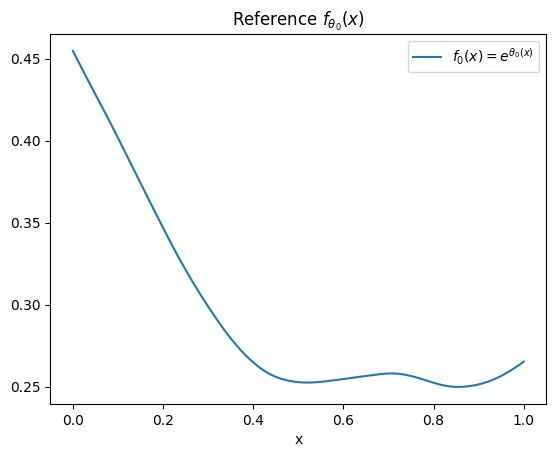

In [214]:
plt.plot(model.xx,model.f_ref, label=r"$f_0(x)=e^{\theta_0(x)}$" )
plt.title(r"Reference $f_{\theta_0}(x)$");
#plt.ylabel(r"$f_{\theta_0}$",  rotation=0);
plt.xlabel(r"x");
plt.legend(loc='best')
plt.show()

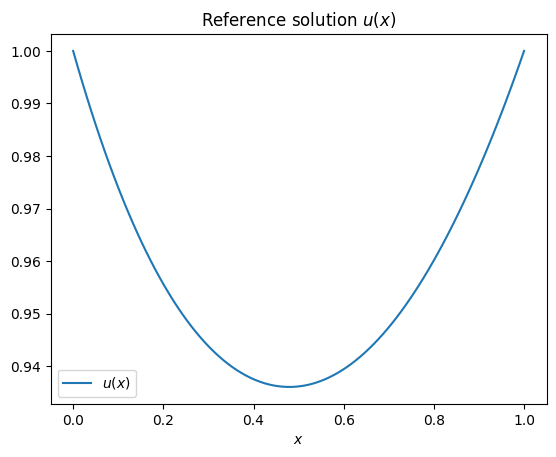

In [215]:
plt.plot(model.xx, model.u_ref, label="$u(x)$")
plt.legend(loc='best')
plt.xlabel("$x$")
plt.title("Reference solution $u(x)$")
plt.show()

In [216]:
samples_nu25, acceptance_prob=perform_pCN(model, 3*10**6, beta=0.5)

Iteration:  300000
Iteration:  600000
Iteration:  900000
Iteration:  1200000
Iteration:  1500000
Iteration:  1800000
Iteration:  2100000
Iteration:  2400000
Iteration:  2700000


In [217]:
print("Average acceptance probability starting from burn in time of 10^6: ", np.mean(acceptance_prob[1*10**6:])*100, "\nOverall average acceptance probability: ", np.mean(acceptance_prob[:])*100)

Average acceptance probability starting from burn in time of 10^6:  35.19599608005034 
Overall average acceptance probability:  34.95907866459981


Correlation between the components of the posterior mean estimator: choose burn-in time for which autocorrelation is low

In [218]:
burnin_t=2*10**6
autocorr_allsamples=ac_components(samples_nu25)
autocorr_burnint=ac_components(samples_nu25[:,burnin_t:])

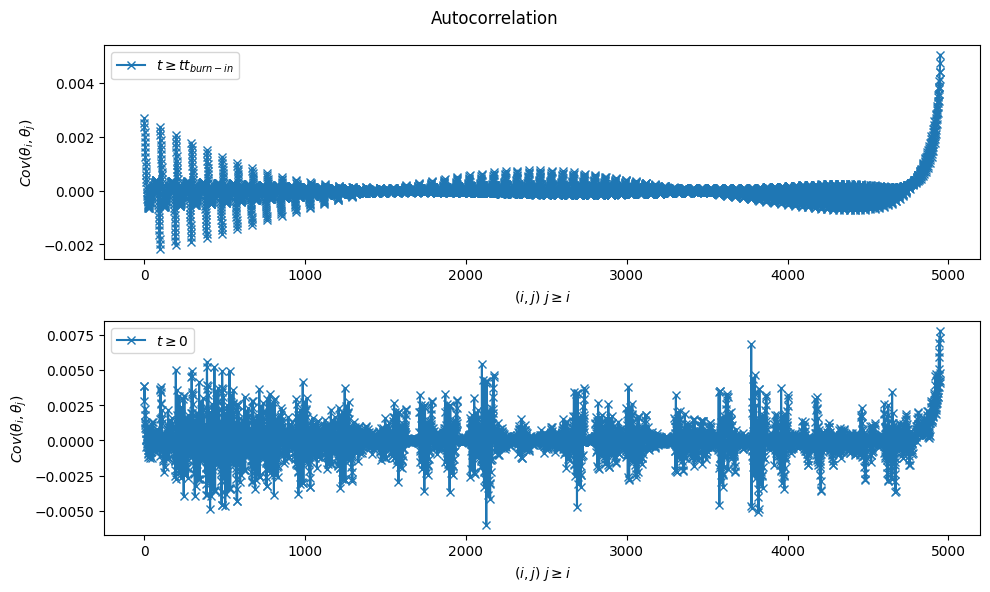

In [229]:
fig, ax=plt.subplots(2,1, figsize=(10,6))
ax[0].plot(autocorr_burnint, marker='x', label='$t\geq tt_{burn-in}$')
ax[0].set_ylabel(r"$Cov(\theta_i, \theta_j)$")
ax[0].set_xlabel(r"$(i,j) \ j\geq i$")
ax[0].legend()
ax[1].plot(autocorr_allsamples, marker='x', label='$t\geq 0$')
ax[1].set_ylabel(r"$Cov(\theta_i, \theta_j)$")
ax[1].set_xlabel(r"$(i,j) \ j\geq i$")
ax[1].legend()
fig.suptitle("Autocorrelation")
fig.tight_layout()

Plot the MCMC estimate obtained with pCN, i.e the posterior sample mean, of the parameter. Set burn-in time to $2\cdot 10^6$

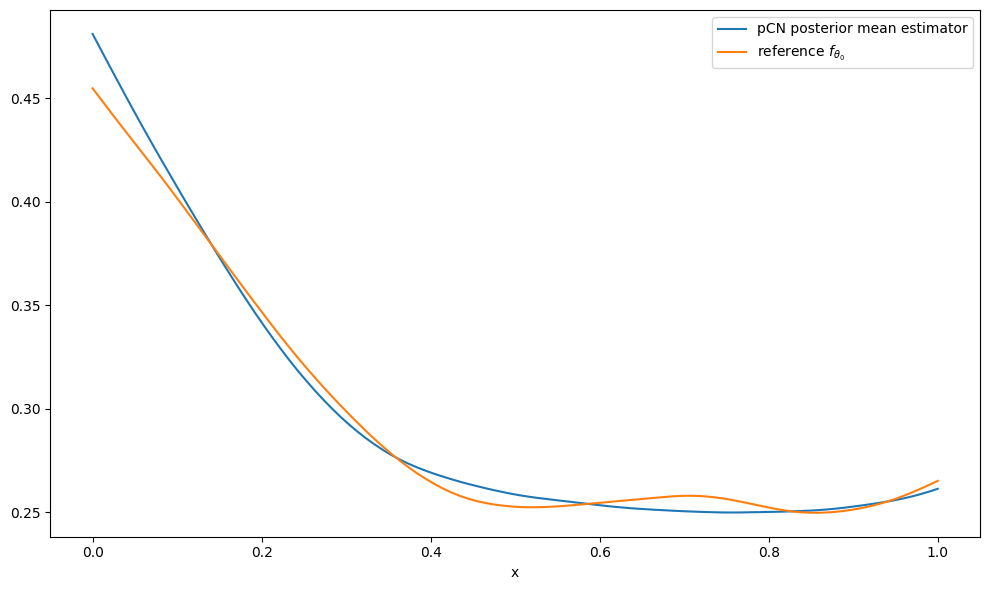

In [225]:
burnin_t=2*10**6
fig, ax=plt.subplots(figsize=(10,6))
mcmc_postmean=np.mean(samples_nu25[:,burnin_t:], axis=1)
ax.plot(model.xx, np.exp(mcmc_postmean), label="pCN posterior mean estimator")
#ax.set_title(r"pCN estimate of $f_{\theta_0}=e^{\theta_0(x)}$ with $T=3*10^6$");
ax.plot(model.xx,model.f_ref, label=r"reference $f_{\theta_0}$")
ax.set_xlabel("x")
ax.legend()
fig.tight_layout()

Comparing the results to the case in which all samples are considered:

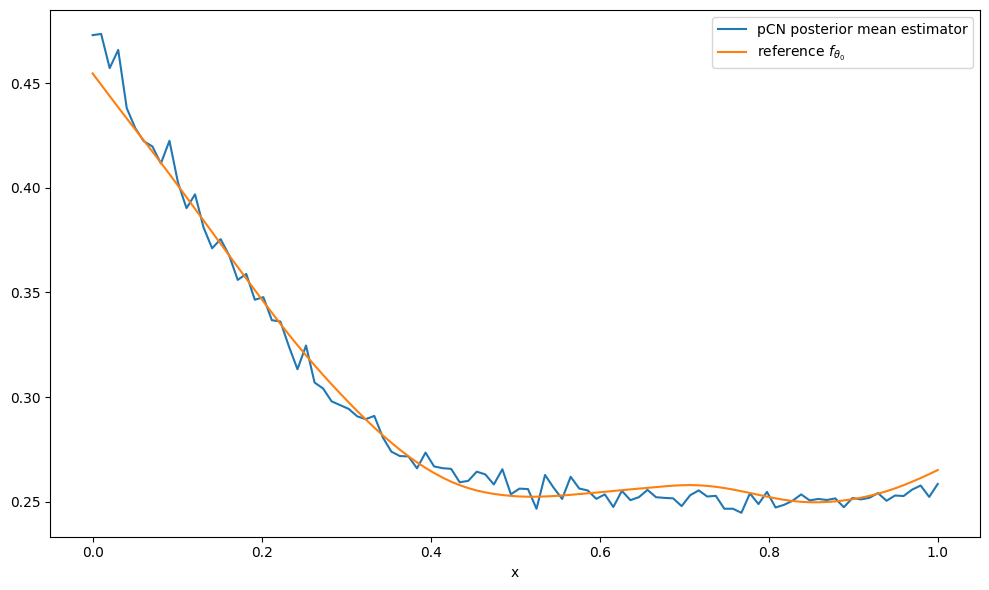

In [224]:
fig, ax=plt.subplots(figsize=(10,6))
mcmc_postmean=np.mean(samples_nu25[:,:], axis=1)
ax.plot(model.xx, np.exp(mcmc_postmean), label="pCN posterior mean estimator")
#ax.set_title(r"pCN estimate of $f_{\theta_0}=e^{\theta_0(x)}$ with $T=3*10^6$");
ax.plot(model.xx,model.f_ref, label=r"reference $f_{\theta_0}$")
ax.set_xlabel("x")
ax.legend()
fig.tight_layout()

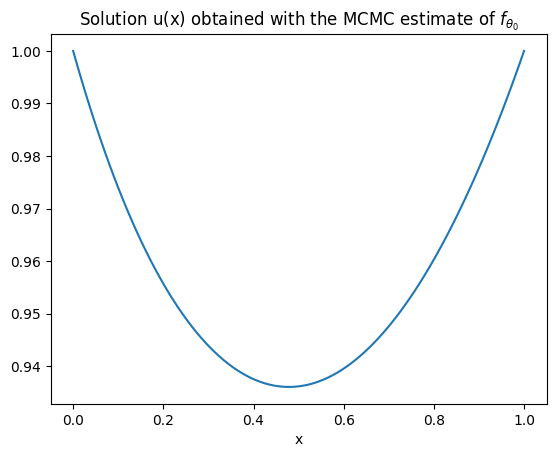

In [226]:
mcmc_postmean=np.mean(samples_nu25[:,burnin_t:], axis=1)
sol=model.solver(np.exp(mcmc_postmean))
plt.plot(model.xx, sol)
plt.xlabel("x")
plt.title(r"Solution u(x) obtained with the MCMC estimate of $f_{\theta_0}$");

Variance of the MCMC posterior mean estimator:

In [227]:
var_mcmc=np.sum((samples_nu25[:,burnin_t:].T-mcmc_postmean)**2, axis=0)/(3*10**6-burnin_t)

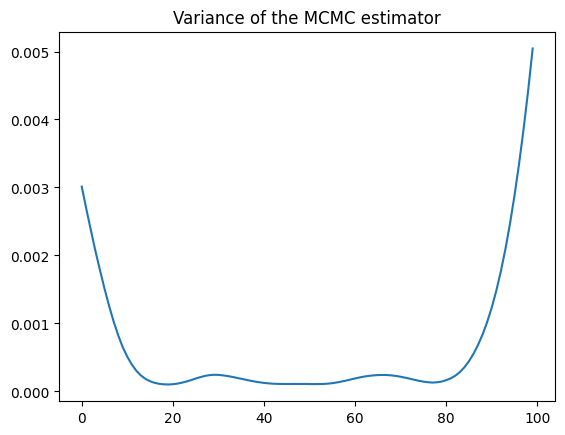

In [228]:
plt.plot(var_mcmc)
plt.title("Variance of the MCMC estimator");

We see that the first and the last components have the largest variance and this in line with the above results for both mcmc posterior mean estimate and autocorrelation.

# $\nu=3.5$

In [193]:
model=Schroedinger1D(N=100, nu_=3.5, noisestd=0.0005)

Plot the reference parametrized function:

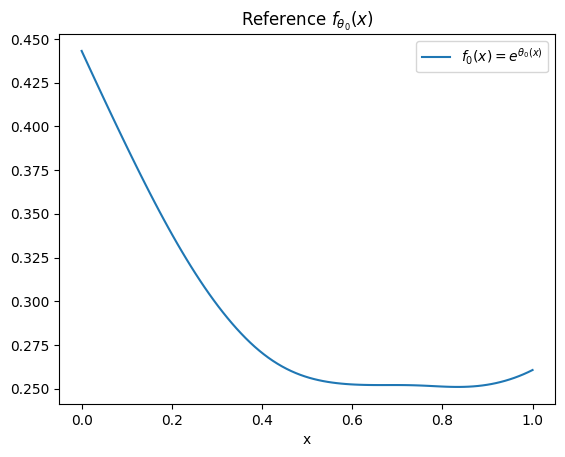

In [194]:
plt.plot(model.xx,model.f_ref, label=r"$f_0(x)=e^{\theta_0(x)}$" )
plt.title(r"Reference $f_{\theta_0}(x)$");
#plt.ylabel(r"$f_0$",  rotation=0);
plt.xlabel(r"x");
plt.legend(loc='best')
plt.show()

Plot reference solution:

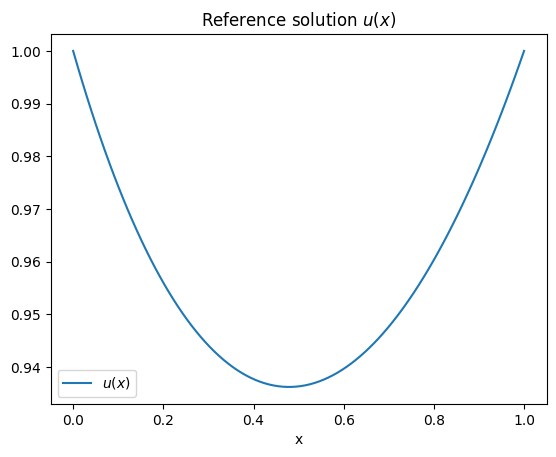

In [195]:
plt.plot(model.xx, model.u_ref, label="$u(x)$")
plt.legend(loc='best')
plt.xlabel("$x$")
plt.title("Reference solution $u(x)$")
plt.xlabel("x")
plt.show()

Plot noisy observations $\{y_i\}_{i=1}^N$ and reference solution:

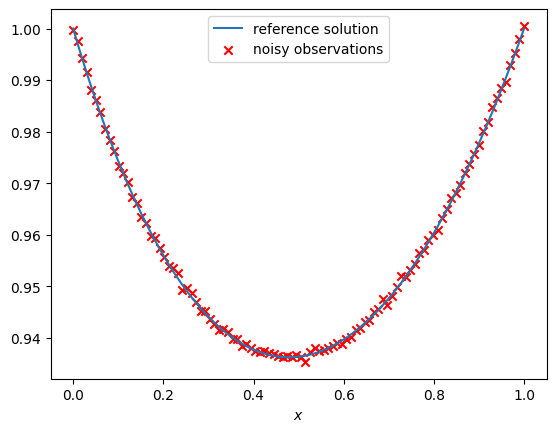

In [196]:
plt.plot(model.xx, model.u_ref, label="reference solution")
plt.scatter(model.xx, model.obs,marker='x', c='r', label="noisy observations")
plt.legend(loc='best')
plt.xlabel("$x$")
plt.show()

Run pCN:

In [8]:
samples, acceptance_prob=perform_pCN(model, 3*10**6, beta=0.5)

Iteration:  300000
Iteration:  600000
Iteration:  900000
Iteration:  1200000
Iteration:  1500000
Iteration:  1800000
Iteration:  2100000
Iteration:  2400000
Iteration:  2700000


In [25]:
print("Average acceptance probability starting with burn in time 10^6: ", np.mean(acceptance_prob[1*10**6:])*100, "\nOverall average acceptance probability: ", np.mean(acceptance_prob[:])*100)

Average acceptance probability starting with burn in time 10^6:  34.45671878701449 
Overall average acceptance probability:  34.3985614898711


Correlation between the components of the posterior mean estimator: test different burn-in times to see when autocorrelation is low.

In [209]:
burnin_t=2*10**6
autocorr_allsamples=ac_components(samples)
autocorr_burnint=ac_components(samples[:,burnin_t:])

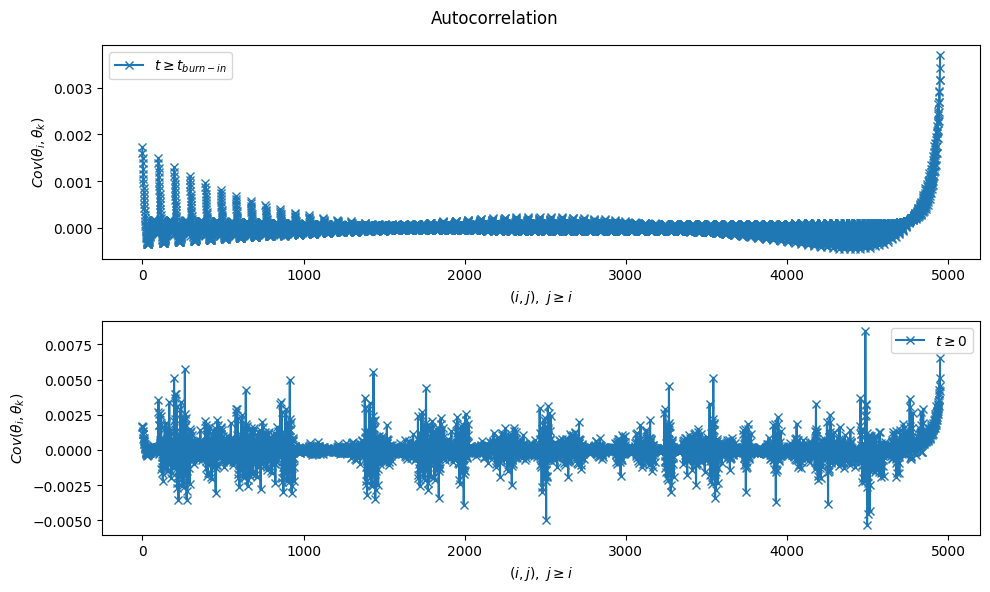

In [210]:
fig, ax=plt.subplots(2,1, figsize=(10,6))
ax[0].plot(autocorr_burnint, marker='x', label='$t\geq t_{burn-in}$')
ax[0].set_ylabel(r"$Cov(\theta_i, \theta_k)$")
ax[0].set_xlabel(r"$(i,j), \ j \geq i$")
ax[0].legend()
ax[1].plot(autocorr_allsamples, marker='x', label='$t\geq 0$')
ax[1].set_ylabel(r"$Cov(\theta_i, \theta_k)$")
ax[1].set_xlabel(r"$(i,j), \ j \geq i$")
ax[1].legend()
fig.suptitle("Autocorrelation")
fig.tight_layout()

The first and the last components seem to have higher correlation with the rest with respect to the other ones.

Plot the pCN estimate, i.e the posterior sample mean, of the parameter: choose the burn-in time according to the autocorrelation plot.

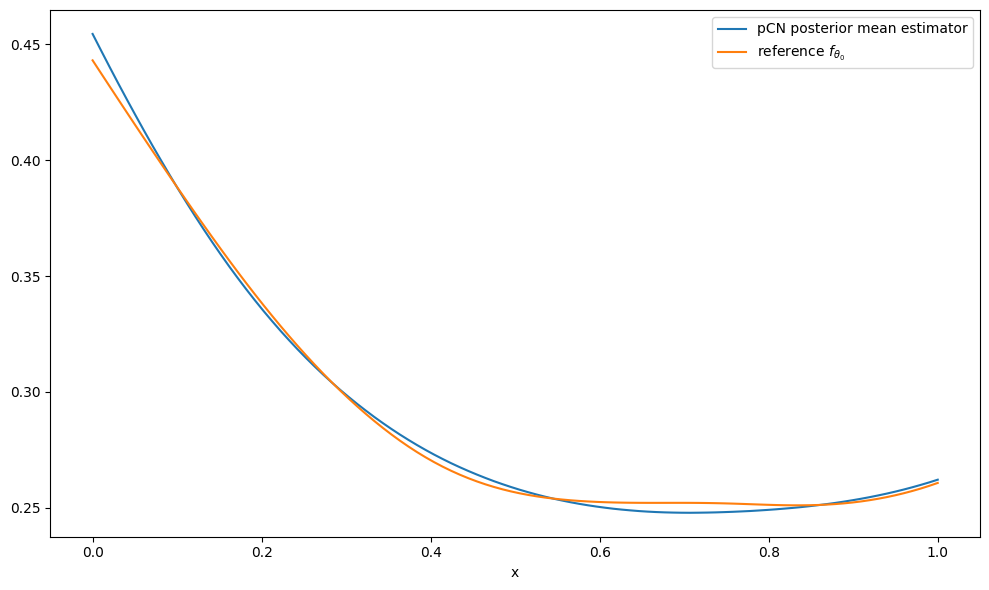

In [201]:
burnin_t=2*10**6
fig, ax=plt.subplots(figsize=(10,6))
mcmc_postmean=np.mean(samples[:,burnin_t:], axis=1)
ax.plot(model.xx, np.exp(mcmc_postmean), label="pCN posterior mean estimator")
#ax.set_title(r"pCN estimate of $f_{0}=e^{\theta_0(x)}$ with $T=3*10^6$");
ax.plot(model.xx,model.f_ref, label=r"reference $f_{\theta_0}$")
ax.set_xlabel("x")
ax.legend()
fig.tight_layout()

Comparing the results to the case in which all samples are considered:

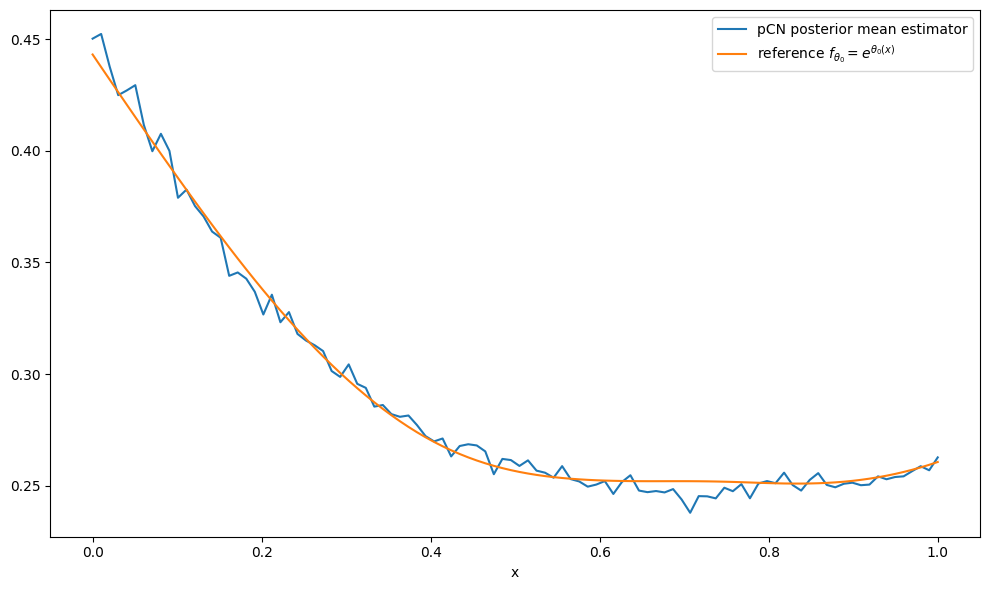

In [176]:
fig, ax=plt.subplots(figsize=(10,6))
mcmc_postmean=np.mean(samples[:,:], axis=1)
ax.plot(model.xx, np.exp(mcmc_postmean), label="pCN posterior mean estimator")
#ax.set_title(r"pCN estimate of $f_{0}=e^{\theta_0(x)}$ with $T=3*10^6$");
ax.plot(model.xx,model.f_ref, label=r"reference $f_{\theta_0}=e^{\theta_0(x)}$")
ax.set_xlabel("x")
ax.legend()
fig.tight_layout()

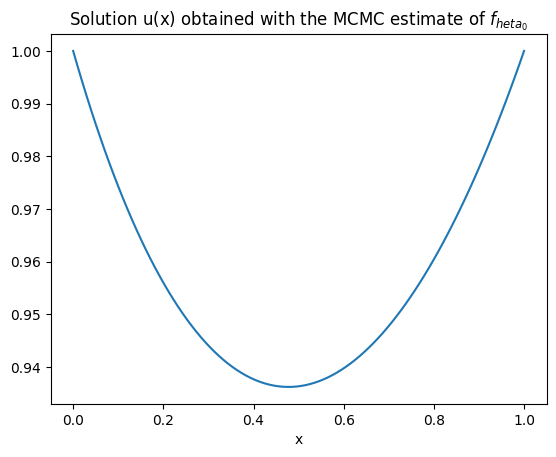

In [188]:
mcmc_postmean=np.mean(samples[:,burnin_t:], axis=1)
sol=model.solver(np.exp(mcmc_postmean))
plt.plot(model.xx, sol)
plt.xlabel("x")
plt.title(r"Solution u(x) obtained with the MCMC estimate of $f_{\theta_0}$");

Text(0.5, 0, 'component')

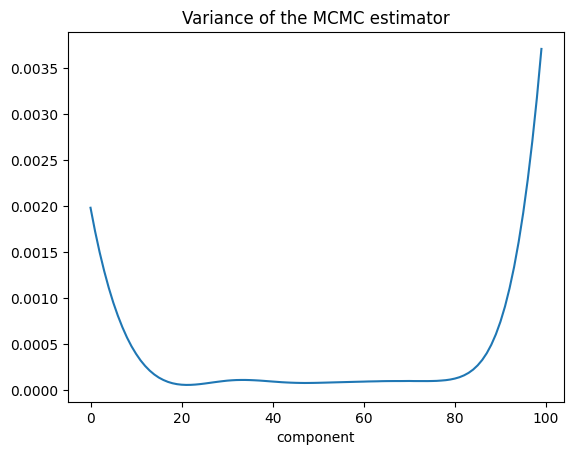

In [179]:
var_mcmc=np.sum((samples[:,burnin_t:].T-mcmc_postmean)**2, axis=0)/(3*10**6-burnin_t)
plt.plot(var_mcmc)
plt.title("Variance of the MCMC estimator");
plt.xlabel("component")

We see that the first and the last components have the largest variance and this is in line with the above results for both mcmc posterior mean estimate and autocorrelation.

# $\nu\to\infty$

In [181]:
model=Schroedinger1D(N=100, nu_='inf', noisestd=0.0005)

Plot the reference parametrized function:

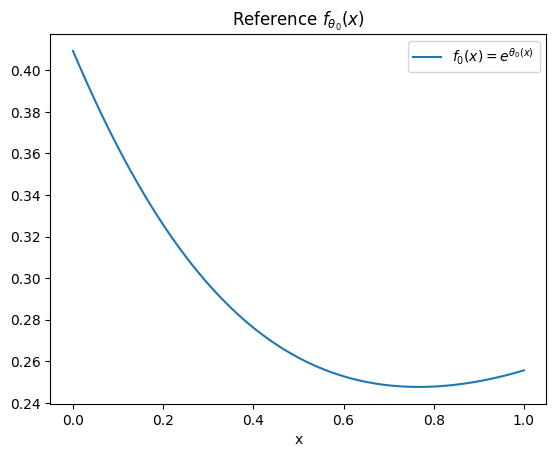

In [182]:
plt.plot(model.xx,model.f_ref, label=r"$f_0(x)=e^{\theta_0(x)}$" )
plt.title(r"Reference $f_{\theta_0}(x)$");
#plt.ylabel(r"$f_0$",  rotation=0);
plt.xlabel(r"x");
plt.legend(loc='best')
plt.show()

Plot reference solution:

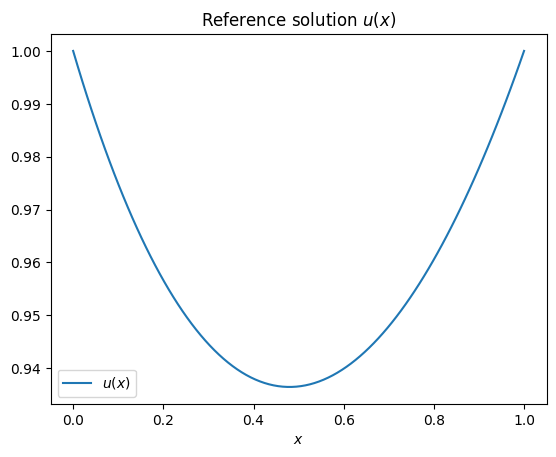

In [183]:
plt.plot(model.xx, model.u_ref, label="$u(x)$")
plt.legend(loc='best')
plt.xlabel("$x$")
plt.title("Reference solution $u(x)$")
plt.show()

Plot noisy observations $\{y_i\}_{i=1}^N$ and reference solution:

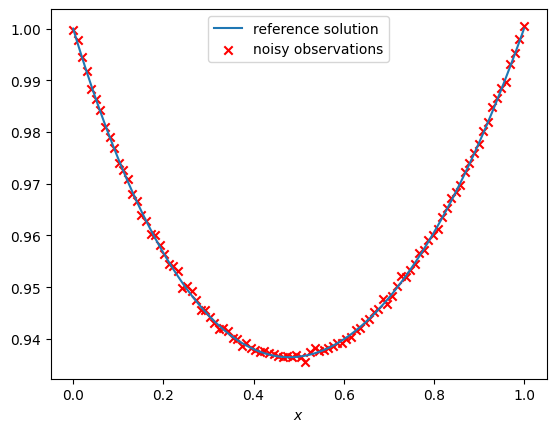

In [158]:
plt.plot(model.xx, model.u_ref, label="reference solution")
plt.scatter(model.xx, model.obs,marker='x', c='r', label="noisy observations")
plt.legend(loc='best')
plt.xlabel("$x$")
plt.show()

Run pCN:

In [77]:
samples_nuinf, acceptance_prob_nuinf=perform_pCN(model, 3*10**6, beta=0.5)

Iteration:  300000
Iteration:  600000
Iteration:  900000
Iteration:  1200000
Iteration:  1500000
Iteration:  1800000
Iteration:  2100000
Iteration:  2400000
Iteration:  2700000


In [78]:
print("Average acceptance probability starting with burn in time 10^6: ", np.mean(acceptance_prob[1*10**6:])*100, "\nOverall average acceptance probability: ", np.mean(acceptance_prob[:])*100)

Average acceptance probability starting with burn in time 10^6:  34.45671878701449 
Overall average acceptance probability:  34.3985614898711


Correlation between the components of the posterior mean estimator: test different burn-in time to see when autocorrelation is low.

In [211]:
burnin_t=2*10**6
autocorr_allsamples=ac_components(samples_nuinf)
autocorr_burnint=ac_components(samples_nuinf[:,burnin_t:])

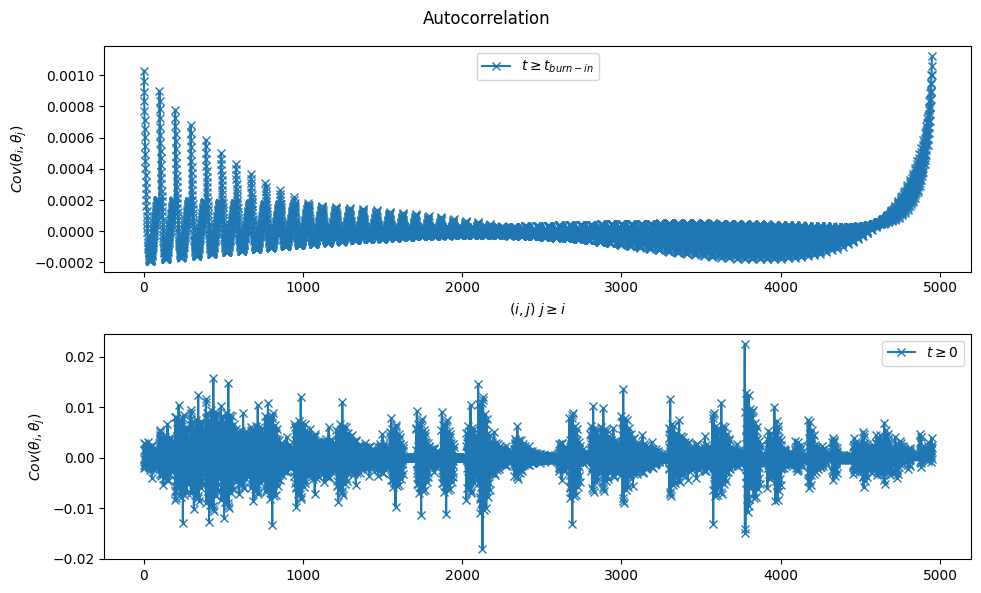

In [212]:
fig, ax=plt.subplots(2,1, figsize=(10,6))
ax[0].plot(autocorr_burnint, marker='x', label='$t\geq t_{burn-in}$')
ax[0].set_ylabel(r"$Cov(\theta_i, \theta_j)$")
ax[0].set_xlabel(r"$(i,j) \ j \geq i$")
ax[0].legend()
ax[1].plot(autocorr_allsamples, marker='x', label='$t\geq 0$')
ax[1].set_ylabel(r"$Cov(\theta_i, \theta_j)$")
ax[0].set_xlabel(r"$(i,j) \ j \geq i$")
ax[1].legend()
fig.suptitle("Autocorrelation")
fig.tight_layout()

The first and the last components seem to have higher correlation with the rest with respect to the other ones. Overall the autocorrelation between the components is lower with respect to  the 2 cases above.

Plot the pCN estimate, i.e the posterior sample mean, of the parameter: choose the burn-in time according to the autocorrelation plot.

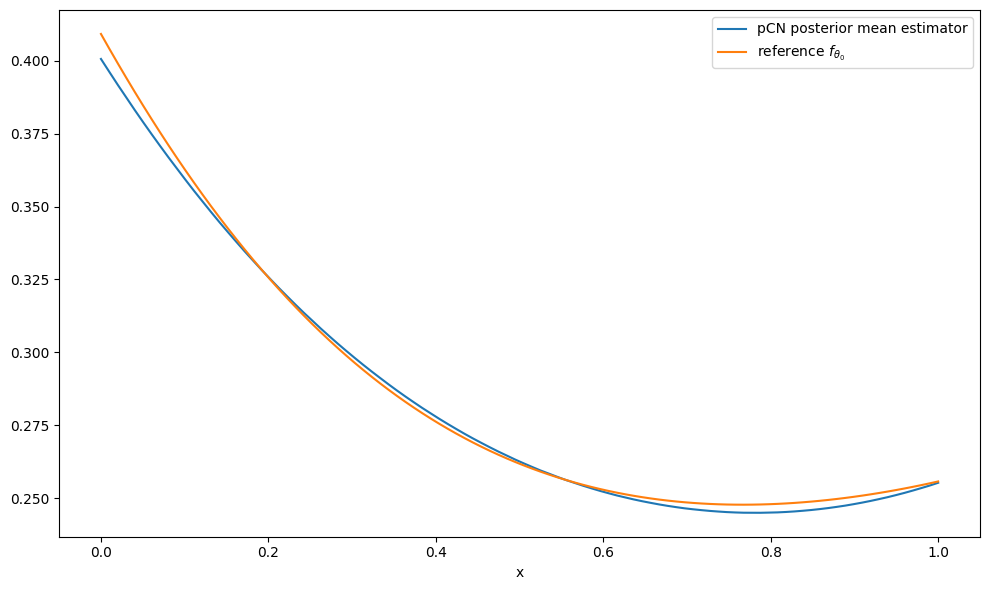

In [184]:
burnin_t=2*10**6
fig, ax=plt.subplots(figsize=(10,6))
mcmc_postmean=np.mean(samples_nuinf[:,burnin_t:], axis=1)
ax.plot(model.xx, np.exp(mcmc_postmean), label="pCN posterior mean estimator")
#ax.set_title(r"pCN estimate of $f_{\theta_0}=e^{\theta_0(x)}$ with $T=3*10^6$");
ax.plot(model.xx,model.f_ref, label=r"reference $f_{\theta_0}$")
ax.set_xlabel("x")
ax.legend()
fig.tight_layout()

Comparing the results to the case in which all samples are considered:

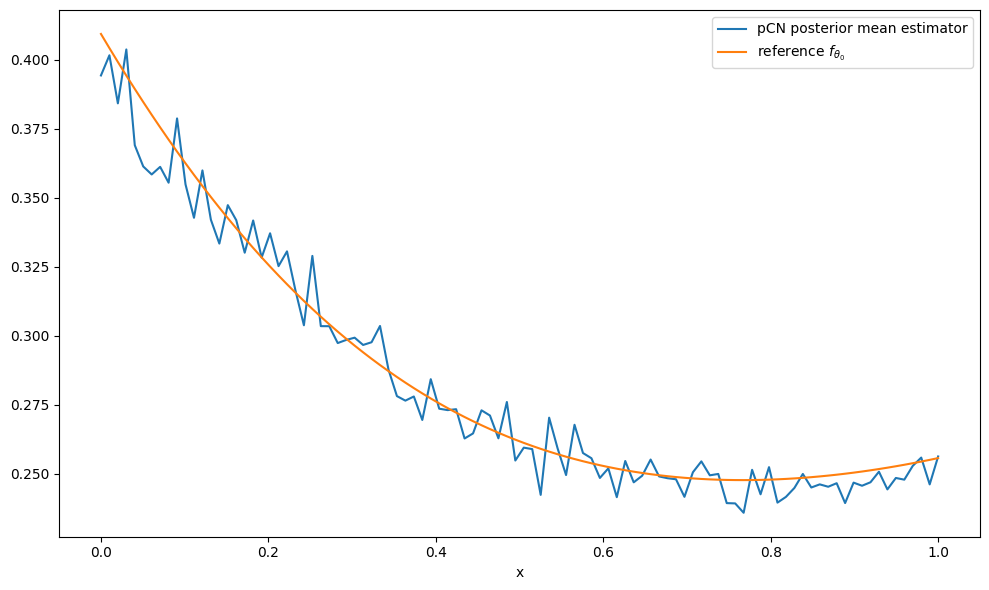

In [185]:
fig, ax=plt.subplots(figsize=(10,6))
mcmc_postmean=np.mean(samples_nuinf[:,:], axis=1)
ax.plot(model.xx, np.exp(mcmc_postmean), label="pCN posterior mean estimator")
#ax.set_title(r"pCN estimate of $f_{\theta_0}=e^{\theta_0(x)}$ with $T=3*10^6$");
ax.plot(model.xx,model.f_ref, label=r"reference $f_{\theta_0}$")
ax.set_xlabel("x")
ax.legend()
fig.tight_layout()

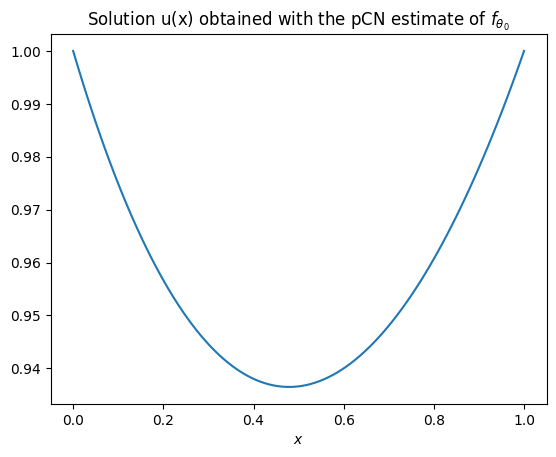

In [186]:
mcmc_postmean=np.mean(samples_nuinf[:,burnin_t:], axis=1)
sol=model.solver(np.exp(mcmc_postmean))
plt.plot(model.xx, sol)
plt.xlabel("$x$")
plt.title(r"Solution u(x) obtained with the pCN estimate of $f_{\theta_0}$");

Text(0.5, 0, 'component')

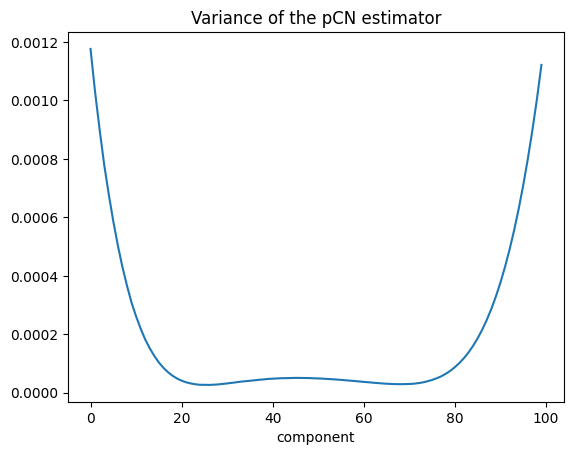

In [187]:
var_mcmc=np.sum((samples_nuinf[:,burnin_t:].T-mcmc_postmean)**2, axis=0)/(3*10**6-burnin_t)
plt.plot(var_mcmc)
plt.title("Variance of the pCN estimator");
plt.xlabel("component")

Try to see what happens when always accepting:

In [230]:
def perform_pCN_biased(model: Schroedinger1D, T: int, beta=0.5):
    """The function performs the preconditioned Crank-Nicolson algorithm  with beta=0.5 as default value and T iterations.
    The parameter beta is tuned online in a way  that the avg acceptance probability is around 30%."""
    acceptance_probs=[]
    samples=np.zeros((model.N, T))
    samples[:,0]=np.random.normal(0,1,model.N) 
    t_up = 100  #update beta every 100 iterations.
    for t in range(1,T):
        if(t>=100):
            proposal=np.sqrt(1-beta**2)*theta_t+beta*model.sample_from_prior()
            samples[:,t]=proposal
        else:
            if (t%t_up == 0) and (t>0) :
                #tune beta--> if avg acceptance prob is too small, reduce it (too large step size leads to many rejection). If avg acceptance prob is too high, increase it (take a larger step size to accept less).
                prob_mean = np.mean(acceptance_probs[-t_up:])
                if prob_mean < 0.001 :
                    beta *= 0.1
                elif prob_mean < 0.05 :
                    beta*=0.5
                elif prob_mean < 0.2 :
                    beta*=0.9
                if prob_mean > 0.5:
                    beta *= 1.1
                elif prob_mean > 0.75:
                    beta *= 2
                elif prob_mean > 0.95:
                    beta *= 10
                
            theta_t=samples[:,t-1]
            u=np.random.uniform(0,1,1)
            proposal=np.sqrt(1-beta**2)*theta_t+beta*model.sample_from_prior()
            acceptance_prob=np.min([0, model.phi(proposal)-model.phi(theta_t)])
            acceptance_prob=np.exp(acceptance_prob)
            acceptance_probs.append(acceptance_prob)
            if(acceptance_prob>u):
                #accept
                samples[:,t]=proposal
            else:
                #reject
                samples[:,t]=theta_t
        
    return samples

In [231]:
model=Schroedinger1D(N=100, nu_='inf', noisestd=0.0005)

In [232]:
samples_nuinf_b=perform_pCN_biased(model, 100000, beta=0.5)

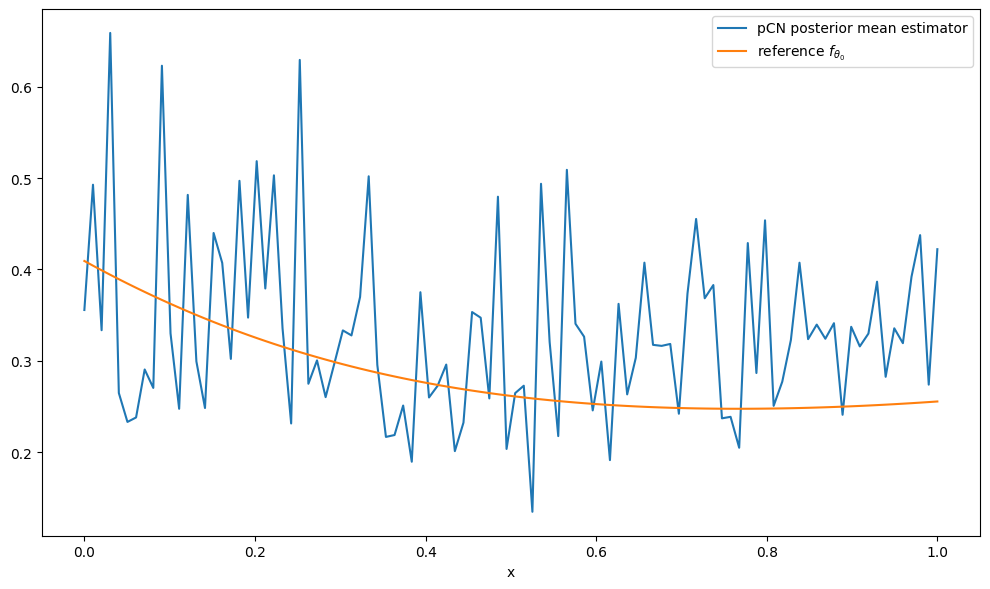

In [238]:
fig, ax=plt.subplots(figsize=(10,6))
mcmc_postmean=np.mean(samples_nuinf_b[0][:,:], axis=1)
ax.plot(model.xx, np.exp(mcmc_postmean), label="pCN posterior mean estimator")
#ax.set_title(r"pCN estimate of $f_{\theta_0}=e^{\theta_0(x)}$ with $T=3*10^6$");
ax.plot(model.xx,model.f_ref, label=r"reference $f_{\theta_0}$")
ax.set_xlabel("x")
ax.legend()
fig.tight_layout()